# Anime Recomendation based on user clustering

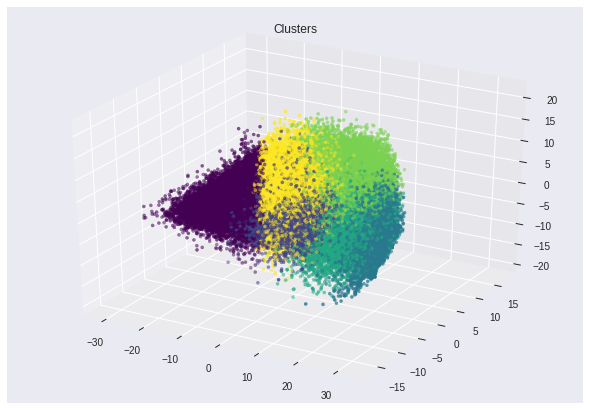
(Image: Spoiler from our projected clusters)


## Introduction

Hi! On this notebook we build a anime recomendation system based on user clustering. 

We have the following available data
* User ratings on animes
* Information about the anime, like genre and type

We leverage both these informations to build our recommendation system. So lets get started!

In [ ]:
#imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Data preparation
First, lets import the datafiles

In [ ]:
rating = pd.read_csv('/kaggle/input/anime-recommendations-database/rating.csv')
rating.head(1)

In [ ]:
anime0 = pd.read_csv('/kaggle/input/anime-recommendations-database/anime.csv')
anime0.head(1)

Next we will extract a feature vector for each anime


In [ ]:
anime = anime0.drop(columns=['name', 'members', 'rating'])

In [ ]:
# spand genre in columns, one for each genre
def func(x):
    if x['genre'] is np.nan:
        return x
    else:
        genres = list(map(lambda y: y.strip(), x['genre'].split(',')))
        for g in genres:
            x[g] = 1
        return x


anime2 = anime.apply(func, axis=1)
anime2.head(1)

In [ ]:
# expand type in columns, one for each type
one_hot = pd.get_dummies(anime2['type'])
one_hot[one_hot == 0] = np.nan
anime3 = (anime2
          .drop(columns=['type', 'episodes', 'genre'])
          .join(one_hot, rsuffix='-type'))
anime3.head(1)

Now we can merge each anime features in the rating table


In [ ]:
rating_anime = rating.join(anime3.set_index('anime_id'), on='anime_id')
rating_anime.head(1)

We have to deal with the -1 rating, which indicates that the user has watched the anime but not rated. Well, we can assume that the user hasn't rated because s/he did not have a good reason to do so (the anime was neither great, nor bad). So we assign a rating of 5 to this animes. It also help us diferenciate between the animes he has watched and not rated (which is preferable) and the ones he has not watched.


In [ ]:
rating_anime.loc[rating_anime['rating'] == -1, 'rating'] = 5
rating_anime.head()

Next, the rating becomes a weight in the anime properties

In [ ]:
# anime3 is the dataframe joined before.
# All columns are anime properties, except anime_id.
attr = anime3.columns.tolist()
attr.remove('anime_id')

rating_anime[attr] = rating_anime[attr].mul(rating_anime['rating'], axis=0)
rating_anime.head(10)

Now we can calculate user preference as the mean values for its gradings in each category


In [ ]:
users = (rating_anime
         .drop(columns=['anime_id', 'rating'])
         .groupby(by='user_id')
         .mean())
users.head()

The nan values in dataframe refers to categories that the user has never watched an anime in. So, its a good hypotesis to assign a 0 grade to then


In [ ]:
users = users.fillna(value=0)
users.head()

Lets evaluate how to reduce dimensionality before applying kmeans


In [ ]:
%matplotlib inline

pca = PCA()
pca.fit(users)
acc_var = np.cumsum(pca.explained_variance_ratio_) 

plt.style.use('seaborn')
plt.plot(range(1, len(acc_var)+1), acc_var)
plt.title('PCA explained variance')
plt.xlabel('Number of Variables')
_ = plt.ylabel('Variance Explained')

Based on the plot above, we choose the number of variables. About 80% of variance explained seems good. 

In [ ]:
number_of_components = 20
pca.set_params(n_components=number_of_components)
pca.fit(users)
users_pca = pca.transform(users)
users_pos_pca = pd.DataFrame(users_pca)
users_pos_pca['user_id'] = users.index
users_pos_pca = users_pos_pca.set_index('user_id')
users_pos_pca.head(1)

## K-means clustering
Now we are ready to clusterize. Kmeans is great, but you have to tell the number of nodes. We try for several number of nodes and choose based on the plot of the quadratic error. The ideia is choosing a value when the curve begins to decrease more slowly. Of course, this is not always very clear, so it is a bit subjective.


In [ ]:
inertia = []
scores = []
for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1)
    kmeans.fit(users_pos_pca)
    inertia.append(kmeans.inertia_)
plt.plot(range(2, 12), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Quadratic Error')
_ = plt.title('K-means error vs number of Clusters')

Great, is not clear at all, but between 4 and 8 seems a good choice. We chose 6.


## Clustering visualization

Now lets plot the clusters (who doesn't love 3d plots?).

To do so we need two things:
* project the users feature vector in 3 dimensions
* find each user's cluster

In [ ]:
#project the users feature vector in 3 dimensions
users_with_label = pd.DataFrame(PCA(n_components=3).fit_transform(users))
users_with_label['user_id'] = users.index
users_with_label = users_with_label.set_index('user_id')

#find each user's cluster
kmeans = KMeans(n_clusters=6, n_init=30, n_jobs=-1)
users_with_label['label'] = kmeans.fit_predict(users_pos_pca)
users_with_label.head()

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(users_with_label[0], users_with_label[1], users_with_label[2], c=users_with_label['label'].to_numpy(), cmap='viridis', s=10)
_ = plt.title('Clusters')

Awesome, we can see the clusters. It is worth to remember the clustering is done in a higher dimensional space than the plot. If you can project a 20-dimensional space in your head, you can probably see them better than that.

Is the clusters well split, though?


In [ ]:
print('Cluster ID     Number of users in cluster')
for idx, val in (pd.get_dummies(users_with_label['label'])).sum().iteritems():
    print(f'{idx}              {val}')

I guess that is a good split


## Create the recomendations. 

We need to evaluate what is a good anime chosen by the group. There are two important factor, average rating and views (Spoiler: I will multiply then together to build a single score). 




First, we join to the rating table the user's cluster.

Differently from before, when the rating assinged is -1, we will ignore it, since we already know the groups and we have a lot of good, non-guessed, ratings.

In [ ]:
rating_user = rating.join(users_with_label[['label']], on='user_id')
rating_user.loc[rating_user['rating'] == -1, 'rating'] = np.nan
rating_user.head(1)

Group the data so we can get the mean rating and the view count for each anime in each user cluster

In [ ]:
groups = (rating_user[['anime_id', 'rating', 'label']]
          .groupby(by=['label', 'anime_id'])
          .rating.agg(['mean', 'count']))
groups.head(2)

Our goodness evaluation (obj - stands for objective) is the mean rating multiplied by the view count.


In [ ]:
groups['obj'] = groups['mean']*groups['count']
groups.head()

if some anime has received no evaluation for some user cluster, obj will be nan. We have so much anime to recomend... just drop those that are nan and we should be fine


In [ ]:
groups_obj = groups[['obj']].dropna()
groups_obj.head(2)

Reorganize this information sorting, for each user cluster, the animes by obj. Replace anime_id by their names and organize everything on a dataframe


In [ ]:
cats = groups_obj.index.get_level_values(0).unique().tolist()
rec = []
for cat in cats:
    rec.append(
        groups_obj
        .loc[cat]
        .sort_values(by='obj', ascending=False)
        .reset_index()
        .join(
            anime0[['name', 'anime_id']].set_index('anime_id'),
            on='anime_id')
        ['name']
        .rename(cat)
    )
rec = pd.concat(rec, axis=1)
rec.head(10)

A lot (really lot) of animes repeat between clusters. Well, that is reasonable, since the most popular animes can be liked by everyone. But, if all recomendations are the same, this is the most useless code of all times. Lets measure how much variability exists between the lists. I find that a good measure is to count unique values overall. If we have more unique values on a fixed lenght list, we have more differences between clusters, as some anime are suggested for one cluster and not for another


In [ ]:
for i in range(2, 20, 2):
    print('First {} recomendations: {} animes in total'
          .format(
              i,
              np.unique(
                  rec
                  .head(i)
                  .to_numpy())
              .shape[0]))


We find that we do have a good variability, so the recomendation system works


# Cheers!
If you like this notebook, don't forget to leave an upvote :)